In [1]:
import numpy as np
import sympy as sp
from matplotlib import pyplot as plt
from tqdm import tqdm

## Estimate parameters of a mass-spring-damper model

We have a model of mass-spring-damper which equation is given by

$$
m\ddot{x} + c\dot{x} + kx = 0
$$

We can rewrite this equation in terms of $\xi$ and $\omega$ to get

$$
\ddot{x} + 2\xi \omega \dot{x} + \omega^2 x = 0
$$

Where

$$
\omega = \sqrt{\dfrac{k}{m}} \ \ \ \ \ \ \ \ \ \ \ \ \ \ 
\xi = \dfrac{c}{2\sqrt{km}}
$$

From now on, we will use a auxiliar term $\mu$ to facilitate the notation

$$
\mu = \sqrt{1-\xi^2}
$$

Then we write the solution response in function of time wth the initial conditions $x_0$ and $v_0$ depending on the parameter $\xi$ and $\omega$. 
Here we will treat only the **underdamped** oscillation ($0 < \xi < 1$) which solution is

$$
x(t) = \exp \left(-\xi \omega t\right) \left[\underbrace{x_0}_{A} \cos \mu \omega t + \underbrace{\left(\frac{\xi}{\mu} x_0 + \frac{1}{\mu \omega} v_0\right)}_{B}\sin \mu \omega t\right]
$$

In [2]:
def solution_underdamped(xi:float, wn:float, t, x0:float, v0:float):
    mu = np.sqrt(1-xi**2)
    x = sp.exp(-xi*wn*t) * (x0 * sp.cos(mu*wn*t) + (xi*x0/mu + v0/(mu*wn)) * sp.sin(mu*wn*t))
    return x

def solution_x(xi:float, wn:float, x0:float, v0:float):
    t = sp.symbols("t")
    if 0 < xi < 1:
        x = solution_underdamped(xi, wn, t, x0, v0)
    else:
        raise Exception("The value of xi must be in (0, 1). Received %.3f" % xi)
    return sp.lambdify(t, x)

def solution_v(xi:float, wn:float, x0:float, v0:float):
    t = sp.symbols("t")
    if 0 < xi < 1:
        x = solution_underdamped(xi, wn, t, x0, v0)
    else:
        raise Exception("The value of xi must be in (0, 1). Received %.3f" % xi)
    v = sp.diff(x, t)
    return sp.lambdify(t, v)

As an example, we will have the following conditions

$$
\xi = 0.2 \ \ \ \ \ \ \ \ \ \ \omega = 1
$$

$$
x_0 = 1 \ \ \ \ \ \ \ \ \ \ v_0 = 1
$$



In [3]:
def initial_conditions():
    wn = 1
    xi = 0.2
    x0, v0 = 1, 1
    return xi, wn, x0, v0

xi, wn, x0, v0 = initial_conditions()
Tn = 2*np.pi/wn  # Natural period
TotalTime = 10*Tn
nplot = 1029
tplot = np.linspace(0, TotalTime, nplot)

Text(0.5, 1.0, 'Exact solution - given parameters')

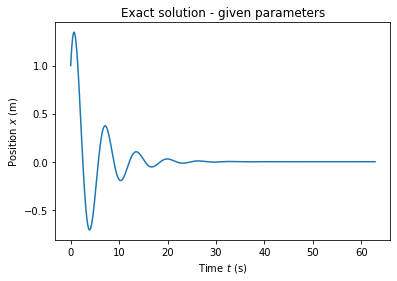

In [4]:
xplot = solution_x(xi, wn, x0, v0)(tplot)
plt.plot(tplot, xplot)
plt.xlabel("Time $t$ (s)")
plt.ylabel("Position $x$ (m)")
plt.title("Exact solution - given parameters")

## Noisy data

For now, we don't have any experimental data (we will have it in the future) and therefore we will add an artificial noise into our known exact data. 
Then we will compare the estimated values (using the noisy values) with the exact parameters values.

There's $n$ values of position $x_i$ mesured at the time $t_i$.

$$
(t_i, x_i)
$$

In [5]:
nsample = 1000 # Quantity of mesured points
tsample = np.linspace(0, TotalTime, nsample)  # Mesured time
uncertainty = 1e-1  # Noise's amplitude
xexact = solution_x(xi, wn, x0, v0)(tsample)
noise = uncertainty*(2*np.random.rand(nsample)-1)
xsample = xexact + noise  # Gotten values at the distance
print("Statistics of the noisy data")
print("    Mean linear distance = %.2e" % np.mean(np.abs(xsample-xexact)))
print("    Mean square distance = %.2e" % np.mean((xsample-xexact)**2))
print("    Sum square distances = %.2e" % np.linalg.norm(xsample-xexact))

Statistics of the noisy data
    Mean linear distance = 4.96e-02
    Mean square distance = 3.28e-03
    Sum square distances = 1.81e+00


We will save the exact values for later

In [6]:
mu = np.sqrt(1-xi**2)
exact_vals = {}
exact_vals["xi"] = xi
exact_vals["mu"] = mu
exact_vals["wn"] = wn
exact_vals["wx"] = -xi * wn
exact_vals["wd"] = mu * wn
exact_vals["x0"] = x0
exact_vals["v0"] = v0
exact_vals["A"] = x0
exact_vals["B"] = xi*x0/mu + v0/(mu*wn)
exact_vals["C"] = np.sqrt(exact_vals["A"]**2 + exact_vals["B"]**2)
exact_vals["phi"] = np.arctan2(exact_vals["A"], exact_vals["B"])
exact_vals["X"] = np.array([exact_vals["A"], exact_vals["B"], exact_vals["wx"], exact_vals["wd"]])

Text(0.5, 1.0, 'Valores ruidosos produtos artificialmente')

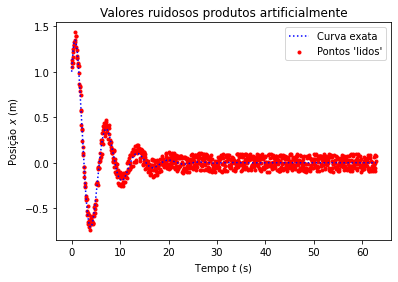

In [7]:
plt.scatter(tsample, xsample, color="r", marker=".", label="Pontos 'lidos'")
plt.plot(tsample, xexact, color="b", ls="dotted", label="Curva exata")
plt.xlabel("Tempo $t$ (s)")
plt.ylabel("Posição $x$ (m)")
plt.legend()
plt.title("Valores ruidosos produtos artificialmente")

## Estimate parameters from noisy values

As we know $\xi<1$ and we will have the solution

$$
x(t) = \exp \left(-\xi \omega t\right) \left[A \cos \left(\mu \omega t\right) + B \sin \left(\mu \omega t\right)\right]
$$

With constants $A$ and $B$ which are dependent on the initial conditions $x_0$ and $v_0$.

As we don't know tha values $A$, $B$, $\xi$ e $\omega$ from the gotten experimental data, we are going to estimate then using the **Least Square Method** on the noisy data.

Let's call $J$ the function that sum the difference's squares.

$$
J = \dfrac{1}{2} \sum_{i} w_{i}\left(x(t_{i}) - x_i\right)^{2}
$$

Where $(t_i, \ x_i)$ are the gotten values from the experiment.
The values of $w_i$ are the **weights** that we will artificially add cause we will consider that the lasts values are less important then the first values and we want to reduce the noise influence from the lasts values.
In a general way, we arbitrally choose

$$
w_{i} = \exp\left(-\dfrac{t_{i}^2}{T_n^2}\right) \ \ \ \ \ \ \ \ \ \ T_n = \dfrac{2\pi}{\omega}  
$$

Where $T_{n}$ is the natural oscillation period.

Therefore, to minimize the function $J$ we get its gradient and set equals zero to get the minimum.

$$
\nabla J = \vec{0} \Leftrightarrow \dfrac{\partial J}{\partial q_i} = 0
$$

And then get an expression to find the parameters.

But, instead of using the parameters $(A, B, \xi, \omega)$, we will use $(A, B, \omega_{x}, \ \omega_{d})$ cause it's more stable and easier to compute on the methods.

$$
\omega_{x} = -\xi \omega \ \ \ \ \ \ \ \ \ \omega_{d} = \mu \omega 
$$

So

$$
x(t) = \exp\left(\omega_{x}t\right)\left(A\cos \omega_{d}t + B\sin \omega_{d} t\right)
$$

As it is a non-linear equation (cause of $\exp$, $\cos$ and $\sin$), we will use the **Newton-Raphson Method** to iterate and achieve the solution. 

$$
x_{j+1} = x_{j} - \dfrac{f(x_j)}{f'(x_j)}
$$

In a our case, from the point $X_{j}$ we compute the next point $X_{j+1}$ using

$$
X_{j+1} = 
X_{j} - \left[\nabla \nabla J\right]^{-1} \cdot \left[\nabla J\right]
$$

Where 

$$
X_{j} = (A_{j}, \ B_{j}, \ \omega_{x,j}, \ \omega_{d,j})
$$


We compute the partial derivatives

$$
\nabla x = \exp \cdot \begin{bmatrix} \cos \\ \sin \\ At\cos + Bt \sin \\ -At\sin + Bt\cos 
\end{bmatrix}
$$

$$
\nabla J = \sum_{i} \left(x(t_i) - x_i\right) \cdot \nabla x(t_i)
$$

$$
\nabla \nabla x = \exp \cdot \begin{bmatrix}
0 & 0 & t \cos & -t \sin \\
& 0 & t \sin & t \cos \\
& & t^2(A\cos + B \sin) & t^2\left(-A\sin + B\cos\right) \\
\text{sym} & & & -t^2 \left(A\cos + B \sin\right)
\end{bmatrix}
$$

$$
\nabla \nabla J = \sum_{i} w_{i} \left[ \nabla x(t_i) \otimes \nabla x(t_i) + x(t_i) \nabla \nabla x(t_i)\right] - w_{i} x_i \nabla \nabla x(t_i)
$$

In a matricial form, we create matrix (to put in the code)

$$
\left[L\right]_{k} = x(t_k)
$$

$$
\left[dL\right]_{ik} = \dfrac{\partial x(t_k)}{\partial q_{i}}  = \left[\nabla x\right]_{i}(t_k)
$$

$$
\left[ddL\right]_{ijk} = \dfrac{\partial^2 x(t_{k})}{\partial q_{i} \partial q_{j}} = \left[\nabla \nabla x\right]_{ij}(t_k)
$$

$$
\left[x\right]_{k} = x_{k}
$$

$$
\left[W\right]_{ik} = \begin{cases}w_{i} \ \ \ \ \text{if} \ i = k \\ 
0 \ \ \ \ \ \ \text{else}\end{cases}
$$

And then we get

$$
\left[B\right] = \left[ \nabla J \right] = \left[dL\right] \cdot \left[W\right] \cdot \left[L\right] - \left[dL\right] \cdot \left[W\right] \cdot \left[x\right]
$$

$$
\left[M\right] = \left[ \nabla \nabla J \right] = \left[dL\right] \cdot \left[W\right] \cdot \left[dL\right] + \left[ddL\right] \cdot \left[W\right] \cdot \left[L\right] - \left[ddL\right] \cdot \left[W\right] \cdot \left[x\right]
$$

In [8]:
def getMB(tvals: np.ndarray, xvals: np.ndarray, Xj: np.ndarray):
    # Given the Xj vector
    #     Xj = (Aj, Bj, wxj, wdj),
    # and the points (ti, xi),
    #     xi = xvals[i]
    #     ti = tvals[i]
    # It returns a [M] and [B] such that
    #     [M] = [nabla nabla J], shape = (4 x 4)
    #     [B] = [nabla J], shape = (4) 
    n = len(xvals)
    m = len(Xj)
    A, B, wx, wd = Xj
    exp = np.exp(wx*tvals)
    cos = np.cos(wd*tvals)
    sin = np.sin(wd*tvals)
    expcos = exp * cos
    expsin = exp * sin
    
    L = A * expcos + B * expsin
    dL = np.zeros((m, n), dtype="float64")
    ddL = np.zeros((m, m, n), dtype="float64")
    
    dL[0] = expcos
    dL[1] = expsin
    dL[2] = tsample * L
    dL[3] = tsample * (-A*expsin + B*expcos)
    
    ddL[0, 2] = ddL[2, 0] = tsample * expcos
    ddL[0, 3] = ddL[3, 0] = -tsample * expsin
    ddL[1, 2] = ddL[2, 1] = -ddL[0, 3]
    ddL[1, 3] = ddL[3, 1] = ddL[0, 2]
    ddL[2, 3] = ddL[3, 2] = tsample * dL[3]
    ddL[2, 2] = tsample * dL[2]
    ddL[3, 3] = - ddL[2, 2]
    
    Tn = 2*np.pi/Xj[3]
    weight = np.exp(-(tvals/Tn)**2)
    # weight = np.ones(len(tvals))
    
    W = np.diag(weight)
    M = dL @ W @ dL.T - ddL @ W @ xvals + ddL @ W @ L
    B = dL @ W @ L - dL @ W @ xvals
    return M, B

#### Estimate the frist point

As we will use Newton's Method, a initial point $X_{0}$ is needed. 
Our objective is find a estimative for $\omega_{x}$ and $\omega_{d}$ and then we will estimate $A$ and $B$ using these two **Least Square Method**, but this one is linear.

Frist, we will filter all the values. It depends on the data we got

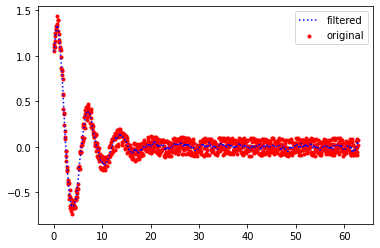

In [9]:
def filter(xvalues: np.ndarray):
    n = len(xvalues)
    b = n//200
    xfiltered = np.zeros(xvalues.shape)
    for i in range(b):
        xfiltered[i] = np.mean(xvalues[:i+1])
    for i in range(b, n-b):
        xfiltered[i] = np.mean(xvalues[i-b:i+b])
    for i in range(n-b, n):
        xfiltered[i] = np.mean(xvalues[i:])
    return xfiltered

xfiltered = filter(xsample)
plt.scatter(tsample, xsample, marker=".", color="red", label="original")
plt.plot(tsample, xfiltered, ls='dotted', color="blue", label="filtered")
plt.legend()

As we know, the function oscilates and we will get the **minimum** and **maximum**. To do that, first we will need the roots $r_{i}$

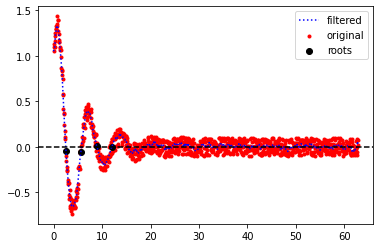

In [10]:
def find_roots(x):
    roots = []
    absx = np.abs(x)
    i = 0
    while len(roots) < 4:
        while x[i] * x[i+1] > 0:
            i += 1
        roots.append(i)
        i = np.where(absx[i:] == np.max(absx[i:]))[0][0] + roots[-1]
    return roots

roots = find_roots(xfiltered)
troots = [tsample[r] for r in roots]
xroots = [xsample[r] for r in roots]
xfiltered = filter(xsample)
plt.scatter(tsample, xsample, marker=".", color="red", label="original")
plt.plot(tsample, xfiltered, ls='dotted', color="blue", label="filtered")
plt.scatter(troots, xroots, color="k", label="roots")
plt.axhline(y=0, ls="dashed", color="k")
plt.legend()

Then we get the period which is the mean of the roots 

$$
T_d = \text{mean}\left(t_{r_{i+1}} - t_{r_{i}}\right)
$$

And as we know it's given by

$$
T_{d} = \dfrac{2\pi}{\omega_{d}}
$$

In another way, we have that the maximums between the roots are given in the index $\alpha$ and $\beta$

$$
x_{\alpha} = C \cdot \exp \left(\omega_{x} t_{\alpha} \right)
$$
$$
x_{\beta} = - C \cdot \exp \left(\omega_{x} t_{\beta} \right)
$$

In that way we will have

$$
\dfrac{x_{\alpha}}{x_{\beta}} = \dfrac{C \exp \left(\omega_{x} t_{\alpha}\right)}{-C \exp \left(\omega_{x} t_{\beta}\right)} = -\exp \left(\omega_{x} \left(t_{\alpha} - t_{\beta}\right)\right) \Rightarrow \omega_{x} = \dfrac{1}{t_{\alpha} - t_{\beta}} \ln \left(\dfrac{-x_{\alpha}}{x_{\beta}}\right)
$$

In [11]:
def get_initial_wxwd(tsample, xsample):
    xfiltered = filter(xsample)
    roots = find_roots(xfiltered)
    xabs = np.abs(xsample)
    r0 = roots[0]
    r1 = roots[1]
    alpha = np.where(xabs[r0:] == np.max(xabs[r0:]))[0][0] + r0
    beta = np.where(xabs[r1:] == np.max(xabs[r1:]))[0][0] + r1

    Td = 2*(tsample[r1] - tsample[r0])
    wd = 2*np.pi/Td
    wx = np.log(-xfiltered[alpha]/xfiltered[beta])/(tsample[alpha] - tsample[beta])
    return wx, wd

wx0, wd0 = get_initial_wxwd(tsample, xsample)
print("wx:")
print("    Estimated: %.3f" % wx0)
print("        Exact: %.3f" % exact_vals["wx"])
print("wd:")
print("    Estimated: %.3f" % wd0)
print("        Exact: %.3f" % exact_vals["wd"])

wx:
    Estimated: -0.158
        Exact: -0.200
wd:
    Estimated: 0.979
        Exact: 0.980


To find the values of $A$ and $B$, we will use the values of $\omega_{x0}$ and $\omega_{d0}$ and find the best curve

$$
\phi(A, B) = \sum_{i} \left(x_i - \exp\left(\omega_{x}t_i\right) \left[A \cos \omega_{d0}t_i + B \sin \omega_{d0}t_i\right]\right)^{2}
$$

The same way, to minimize $\phi(A, B)$ we have

$$
\sum_{i}
\begin{bmatrix}
y_i^2 & y_i z_i \\
y_i z_i & z_i^2
\end{bmatrix}
\begin{bmatrix}
A \\ B
\end{bmatrix} =
\sum_{i}
\begin{bmatrix}
x_i y_i \\
x_i z_i \\
\end{bmatrix}
$$

With

$$
y_{i} = \exp \left(\omega_{x}t_i\right) \cos \left(\omega_{d} t_{i}\right)
$$
$$
z_{i} = \exp \left(\omega_{x}t_i\right) \sin \left(\omega_{d} t_{i}\right)
$$

In [12]:
def get_initial_AB(tsample, xsample, wx, wd):
    exp = np.exp(wx*tsample)
    L = np.array([exp*np.cos(wd*tsample), exp*np.sin(wd*tsample)])
    return np.linalg.solve(L @ L.T, L @ xsample)

A0, B0 = get_initial_AB(tsample, xsample, wx0, wd0)
C0 = np.sqrt(A0**2 + B0**2)
print("A:")
print("    Estimated: %.3f" % A0)
print("        Exact: %.3f" % exact_vals["A"])
print("B:")
print("    Estimated: %.3f" % B0)
print("        Exact: %.3f" % exact_vals["B"])
print("C:")
print("    Estimated: %.3f" % C0)
print("        Exact: %.3f" % exact_vals["C"])

A:
    Estimated: 0.926
        Exact: 1.000
B:
    Estimated: 1.055
        Exact: 1.225
C:
    Estimated: 1.404
        Exact: 1.581


Now we mount the initial vector $X_0$ to iterate

In [13]:
X = np.array([A0, B0, wx0, wd0])
print("X: ")
print("    Estimate = ", X)
print("       Exact = ", exact_vals["X"])

X: 
    Estimate =  [ 0.9264981   1.0545999  -0.15798516  0.97941176]
       Exact =  [ 1.          1.22474487 -0.2         0.9797959 ]


Now we iterate to solve. But at first, we will define functions to evaluate how good the current solution is

In [14]:
def compute_residuo(tvals, xvals, X):
    xi, wn, x0, v0 = transform_X2Z(X)
    xtest = solution_x(xi, wn, x0, v0)(tvals)
    return np.linalg.norm(xtest - xvals)
    
def compute_error(Xgood, Xtest):
    diff = Xgood-Xtest
    divisor = np.copy(Xgood)
    divisor[divisor<1e-9] = 1
    return np.max(diff/divisor)

def transform_X2Z(X):
    A, B, wx, wd = X
    wn = np.sqrt(wx**2 + wd**2)
    xi = -wx/wn
    x0 = A
    v0 = B * wd - xi * wn * x0
    return xi, wn, x0, v0

 ---- Begin ---- 
X0 =  [ 0.9264981   1.0545999  -0.15798516  0.97941176]
    Error =  0.13892278814401374
    Residuo =  1.9662294633486992
 ---- Iteration 1 ---- 
X1 =  [ 0.96824768  1.11400548 -0.1766998   0.97940901]
    Error =  0.09041833409670812
    Residuo =  1.8419428163042542
 ---- Iteration 2 ---- 
X2 =  [ 0.98829892  1.15137465 -0.18790926  0.98037896]
    Error =  0.05990653621329056
    Residuo =  1.8093871008353237
 ---- Iteration 3 ---- 
X3 =  [ 0.99792977  1.17303145 -0.19424775  0.98121816]
    Error =  0.04222383195835613
    Residuo =  1.8029449709968939
 ---- Iteration 4 ---- 
X4 =  [ 1.00260124  1.18484851 -0.19766515  0.98175212]
    Error =  0.032575245961861204
    Residuo =  1.8026986883424618
 ---- Exact ----
X =  [ 1.          1.22474487 -0.2         0.9797959 ]
    Residuo =  1.811198946043435
Difference residuo:
    8.50e-03


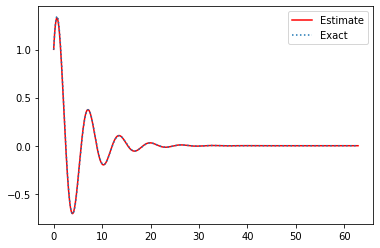

In [15]:
print(" ---- Begin ---- ")    
print("X0 = ", X)
print("    Error = ", compute_error(exact_vals["X"], X))
print("    Residuo = ", compute_residuo(tsample, xsample, X))

for zr in range(4):  # Numero de iteracoes
    M, B = getMB(tsample, xsample, X)
    X -= 0.5*np.linalg.solve(M, B)
    error = compute_error(exact_vals["X"], X)
    residuo = compute_residuo(tsample, xsample, X)
    print(" ---- Iteration %d ---- " % (zr+1))
    print("X%d = " % (zr+1), X)
    print("    Error = ", error)
    print("    Residuo = ", residuo)
exact_residuo = compute_residuo(tsample, xsample, exact_vals["X"])
print(" ---- Exact ----")
print("X = ", exact_vals["X"])
print("    Residuo = ", exact_residuo)
print("Difference residuo:")
print("    %.2e" % np.abs(residuo - exact_residuo))
xi, wn, x0, v0 = transform_X2Z(X)
plt.plot(tsample, solution_x(xi, wn, x0, v0)(tsample), color="r", label="Estimate")
plt.plot(tplot, xplot, ls="dotted", label="Exact")
plt.legend()

#### Map convergence for many $x_0$ and $v_0$

Now we will verify if our solution to find the parameters is good when we change the initial conditions $(x_0, v_0)$.
Now we will create a function that will receive all the points $(t_i, \ x_i)$ and returns the estimate values for $X$.
In the code above, we only considered $5$ iterations, but now we will will control it by the ```residuo```. We will put a tolerance and when the ```residuo``` doesn't change, it means we found the solution.

In [16]:
def find_initial_vector(tsample:np.ndarray, xsample:np.ndarray):
    wx0, wd0 = get_initial_wxwd(tsample, xsample)
    A0, B0 = get_initial_AB(tsample, xsample, wx0, wd0)
    return np.array([A0, B0, wx0, wd0])

def LeastSquare(tsample, xsample, tolerance=1e-6, nitermax = 10, verbose=False):
    X = find_initial_vector(tsample, xsample)
    oldresiduo = 0
    if verbose:
        print(" ---- Begin ---- ")
    for niter in range(nitermax):
        residuo = compute_residuo(tsample, xsample, X)
        if verbose:
            print("    X%d = " % niter, X)
            print("    Residuo = ", residuo)
        if np.abs(residuo - oldresiduo) < tolerance:
            break
        oldresiduo = residuo
        M, B = getMB(tsample, xsample, X)
        X -= np.linalg.solve(M, B)
    return X

100%|██████████| 33/33 [05:00<00:00,  9.11s/it]


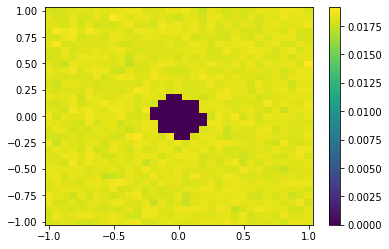

In [17]:
xi = exact_vals["xi"]
wn = exact_vals["wn"]
Tn = 2*np.pi/wn
uncertainty = 1e-3

x0s = np.linspace(-1, 1, 33)
v0s = np.linspace(-1, 1, 33)
residuos = np.zeros((len(x0s), len(v0s)))
nsample = 1001
tsample = np.linspace(0, 10*Tn, nsample)
for i, x0 in enumerate(tqdm(x0s)):
    for j, v0 in enumerate(v0s):
        A = x0
        B = xi*x0/mu + v0/(mu*wn)
        C = np.sqrt(A**2 + B**2)
        if C < 0.2:
            continue
        xsample = solution_x(xi, wn, x0, v0)(tsample)
        xsample += uncertainty*(2*np.random.rand(nsample)-1)
        X = LeastSquare(tsample, xsample, verbose=False)
        residuos[i, j] = compute_residuo(tsample, xsample, X)
fig, axes = plt.subplots()
c = axes.pcolormesh(x0s, v0s, residuos, shading="nearest")
fig.colorbar(c)